# Replay Extraction
## Luke Sullivan

In [14]:
##########################
# Imports
##########################
import pandas as pd
import numpy as np
import cv2
from pytesseract import pytesseract
from random import sample
import matplotlib.pyplot as plt

## I. Introduction

## II. Broadcast Download

In [15]:
## yt-dlp

In [16]:
path = "test1.mp4"

## III. Frame Extraction

In [17]:
def frame_extraction(path):
    cap = cv2.VideoCapture(path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cap.release()
    return frames

### [Figure 1] Extracted Frames (before preprocessing)

In [18]:
def display_frames(frames, num_frames=3):
    if len(frames) < num_frames:
        print(f"Video has less than {num_frames} frames.")
        return
    
    random_frames = sample(frames, num_frames)
    
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    fig.suptitle(f'{num_frames} Random Frames from Video')
    
    for i, frame in enumerate(random_frames):
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'Frame {i+1}')
    
    plt.tight_layout()
    plt.show()

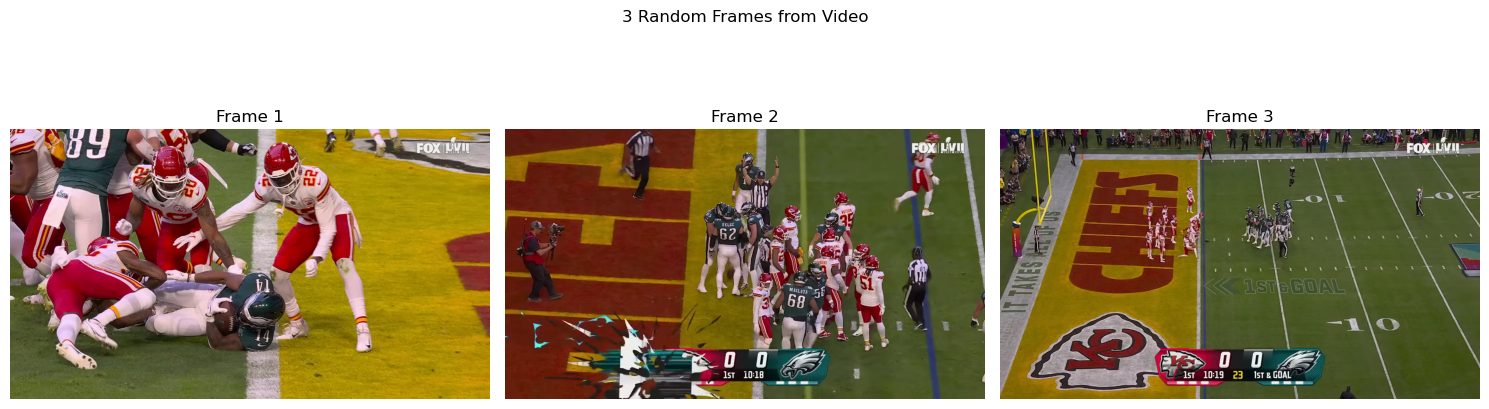

In [19]:
frames = frame_extraction(path)
display_frames(frames)

## IV. Frame Preprocessing

In [21]:
def gt_preprocessing(frames):
    preprocessed_frames = []
    for frame in frames:
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Downsample by factor of 2
        gray = cv2.resize(gray, (gray.shape[1]//2, gray.shape[0]//2))
        
        # Apply illumination adjustment using top-hat filtering
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        gray = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
        
        preprocessed_frames.append(gray)
    
    return preprocessed_frames

In [22]:
preprocessed_frames = gt_preprocessing(frames)

### [Figure 2] Extracted Frames (after preprocessing)

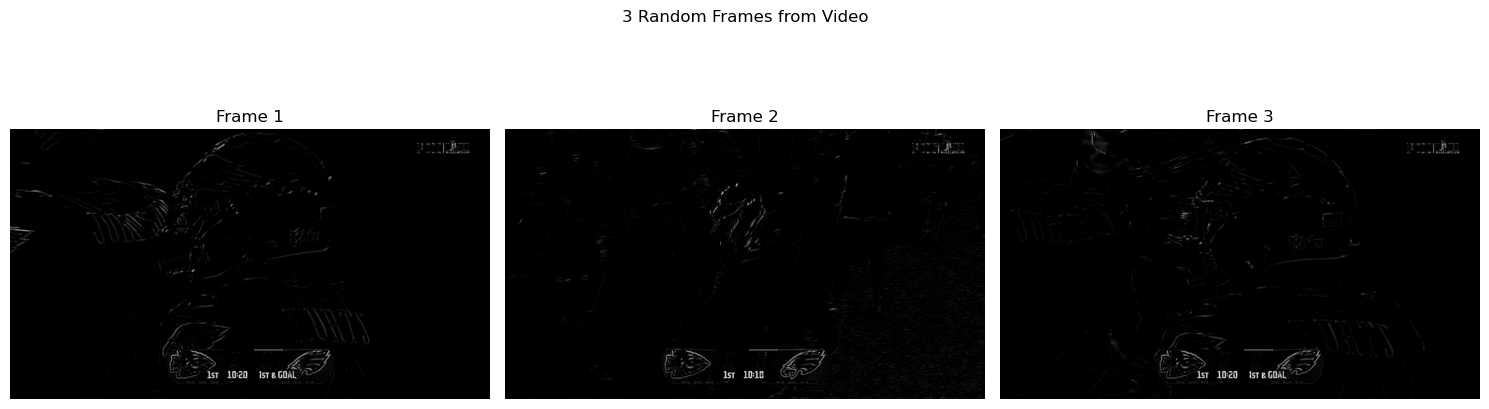

In [23]:
display_frames(preprocessed_frames)

## V. Adaptive Thresholds

In [24]:
def calculate_adaptive_thresholds(frames):
    hist_diffs = []
    for i in range(len(frames) - 1):
        hist_diff = cv2.compareHist(cv2.calcHist([frames[i]], [0], None, [256], [0,256]),
                                    cv2.calcHist([frames[i+1]], [0], None, [256], [0,256]),
                                    cv2.HISTCMP_CHISQR)
        hist_diffs.append(hist_diff)
    
    T_L = np.mean(hist_diffs) - 0.5 * np.std(hist_diffs)
    T_U = np.mean(hist_diffs) + 2 * np.std(hist_diffs)
    return T_L, T_U

In [25]:
def analyze_histogram(frames):
    # Calculate histogram differences using cv2.compareHist
    hist_diffs = [
        cv2.compareHist(cv2.calcHist([frames[i]], [0], None, [256], [0, 256]),
                        cv2.calcHist([frames[i + 1]], [0], None, [256], [0, 256]),
                        cv2.HISTCMP_CHISQR)
        for i in range(len(frames) - 1)
    ]

    # Convert hist_diffs to a NumPy array for statistical calculations
    hist_diffs = np.array(hist_diffs)

    # Plot histogram with adjustments
    plt.hist(hist_diffs, bins=100, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Histogram of Frame Differences')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.yscale('log')  # Logarithmic scale for better visibility
    plt.show()

    # Calculate statistics
    max_value = np.max(hist_diffs)
    min_value = np.min(hist_diffs)
    range_value = max_value - min_value
    mean_value = np.mean(hist_diffs)
    median_value = np.median(hist_diffs)

    # Print statistics
    print(f"Max: {max_value}")
    print(f"Min: {min_value}")
    print(f"Range: {range_value}")
    print(f"Mean: {mean_value}")
    print(f"Median: {median_value}")

### [Figure 3] Histogram of Frame Differe

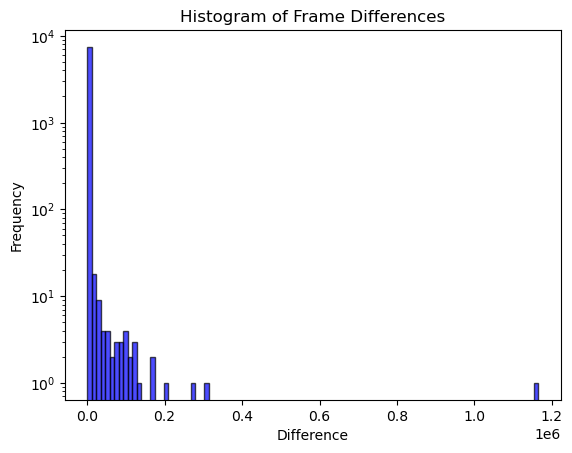

Max: 1164303.1879810544
Min: 0.0
Range: 1164303.1879810544
Mean: 1140.9658406045467
Median: 386.74520081526606


In [26]:
analyze_histogram(preprocessed_frames)

## VI. Gradual Transition Detection